In [331]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_tweedie_deviance
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score

import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

In [332]:
p = 40
q = 10
d = 1
window_size = 5

### Вспомогательные функции ###

In [333]:
def squares_summ(p, data):
    def fun(args):
        sum = 0
        for t in range(p, len(data)):
            s = 0
            for j in range(0, p):
                s += args[j] * data[t - j - 1]
            sum += (data[t] - s)**2
        return sum
    return fun


def prediction(coeffs, data, length):
    result = [0]*length
    for i in range(len(data)):
        result[i] = data[i]
    for i in range(len(data), length):
        sum = 0
        for j in range(1, len(coeffs) + 1):
            sum += result[i - j] * coeffs[j - 1]
        result[i] = sum
    return result


def I(d, data):
    prev = data.copy()
    reverting = []
    for i in range(d):
        reverting.append(prev.copy().array[i])
        prev = prev - prev.shift(1)
    return reverting, prev.array[d:]


def deI(d, data, reverting):
    for i in range(d):
        data.insert(0, reverting[d - i - 1])
        for j in range(1, len(data)):
            data[j] += data[j - 1]
    return data

### AR, MA, I и ARIMA ###

In [334]:
def AR(p, data, await_length):
    coeffs = scipy.optimize.minimize(
        squares_summ(p, data), [0]*(p), method="bfgs").x
    return prediction(coeffs, data, await_length)


def MA(q, data, await_length):
    MA_t = [0]*len(data)
    errors = [0]*len(data)

    for i in range(len(data)):
        MA_t[i] = (1 / window_size) * sum(data[i:i+window_size])

    for i in range(len(data)):
        errors[i] = data[i] - MA_t[i]

    errors_coeffs = scipy.optimize.minimize(squares_summ(q, errors), [
        0 for i in range(q)], method="bfgs").x
    return prediction(errors_coeffs, errors, await_length)


def MY_ARIMA(p, q, d, data, await_length, start):
    df_price_log = np.log(data)
    rev, df_price_diff = I(d, df_price_log)
    priceDiff = pd.Series(df_price_diff)
    predscaz = AR(p, priceDiff.array[:start], await_length)
    errors_predscaz = MA(q, priceDiff.array[:start], await_length)
    for i in range(len(data), await_length):
        predscaz[i] += 0.1 * errors_predscaz[i]
    noShift = deI(d, predscaz, rev)
    return pd.Series(np.exp(noShift))

### Библиотечная реализация ARIMA ###

In [335]:
def LIB_ARIMA(d, p, q, data):
    time_series = np.log(data)

    train_size = int(len(time_series) * 0.8)
    train_data, test_data = time_series[:train_size], time_series[train_size:]

    model = ARIMA(train_data, order=(p, d, q)).fit()

    model_fit = model

    return pd.Series(np.exp(model_fit.predict(start=len(train_data), end=len(time_series)-1)))


def MAPE(expect, actual):
    sum = 0.
    for i in range(len(expect)):
        sum += abs(expect[i] - actual[i])/actual[i]
    return sum*100/len(expect)


In [336]:
df = pd.read_csv('./meow.csv')
df['Цена'] = pd.to_numeric(df['Цена'])
df['Дата'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')

df.sort_index(inplace=True)

df = df.drop(['Откр.', 'Макс.', 'Мин.', 'Изм. %'], axis=1)
df['ЦенаLog'] = np.log(df['Цена'])
df['ЦенаDiff'] = df['ЦенаLog'] - df['ЦенаLog'].shift(1)
priceDiff = df['ЦенаDiff']
p_value = adfuller(priceDiff[1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


### Сравнение с библиотечной реализацией и с оригинальным рядом ###

/home/nypiaka/IdeaProjects/DA/timeseries-Nypiaka/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Дата'>

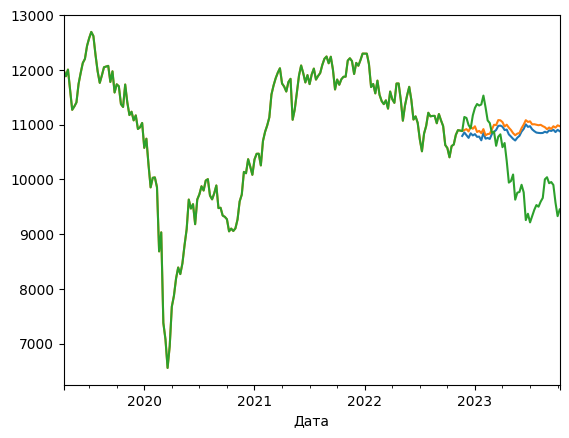

In [337]:
df['ПредсказNoDiff'] = MY_ARIMA(p, q, d, df['Цена'], 235, 188)

la = LIB_ARIMA(d, p, q, df['Цена'])

df['Либа'] = la

df = df.set_index(['Дата'])

df['Либа'].plot()
df['ПредсказNoDiff'].plot()
df['Цена'].plot()

In [338]:
print("MAPE: " + str(MAPE(la.array.tolist(), df['ПредсказNoDiff'].array.tolist()[188:])))

MAPE: 0.8569636363523172


In [339]:
y_true = df['Цена'].values.tolist()
y_predict = df['ПредсказNoDiff'].values.tolist()
print("mse: "+str(mean_squared_log_error(y_true, y_predict)))
print("mape: "+str(mean_absolute_percentage_error(y_true, y_predict)))
print("median absolute error: "+str(median_absolute_error(y_true, y_predict)))
print("mean gamma deviance: " + str(mean_gamma_deviance(y_true, y_predict)))
print("mean tweedie deviance: " + str(mean_tweedie_deviance(y_true, y_predict)))
print("accuracy: " + str(accuracy_score(np.round(y_true), np.round(y_predict))))
print("precision micro: " + str(precision_score(np.round(y_true),
      np.round(y_predict), average='micro')))
print("jaccard micro: " + str(jaccard_score(np.round(y_true),
      np.round(y_predict), average='micro')))

mse: 0.0018578603628221528
mape: 0.016798549694975583
median absolute error: 5.4569682106375694e-12
mean gamma deviance: 0.001779292721012913
mean tweedie deviance: 196705.47224436083
accuracy: 0.8042553191489362
precision micro: 0.8042553191489362
jaccard: 0.6725978647686833


### Декомпозиция оригинального ряда ###

<Axes: title={'center': 'Residual'}, xlabel='Дата'>

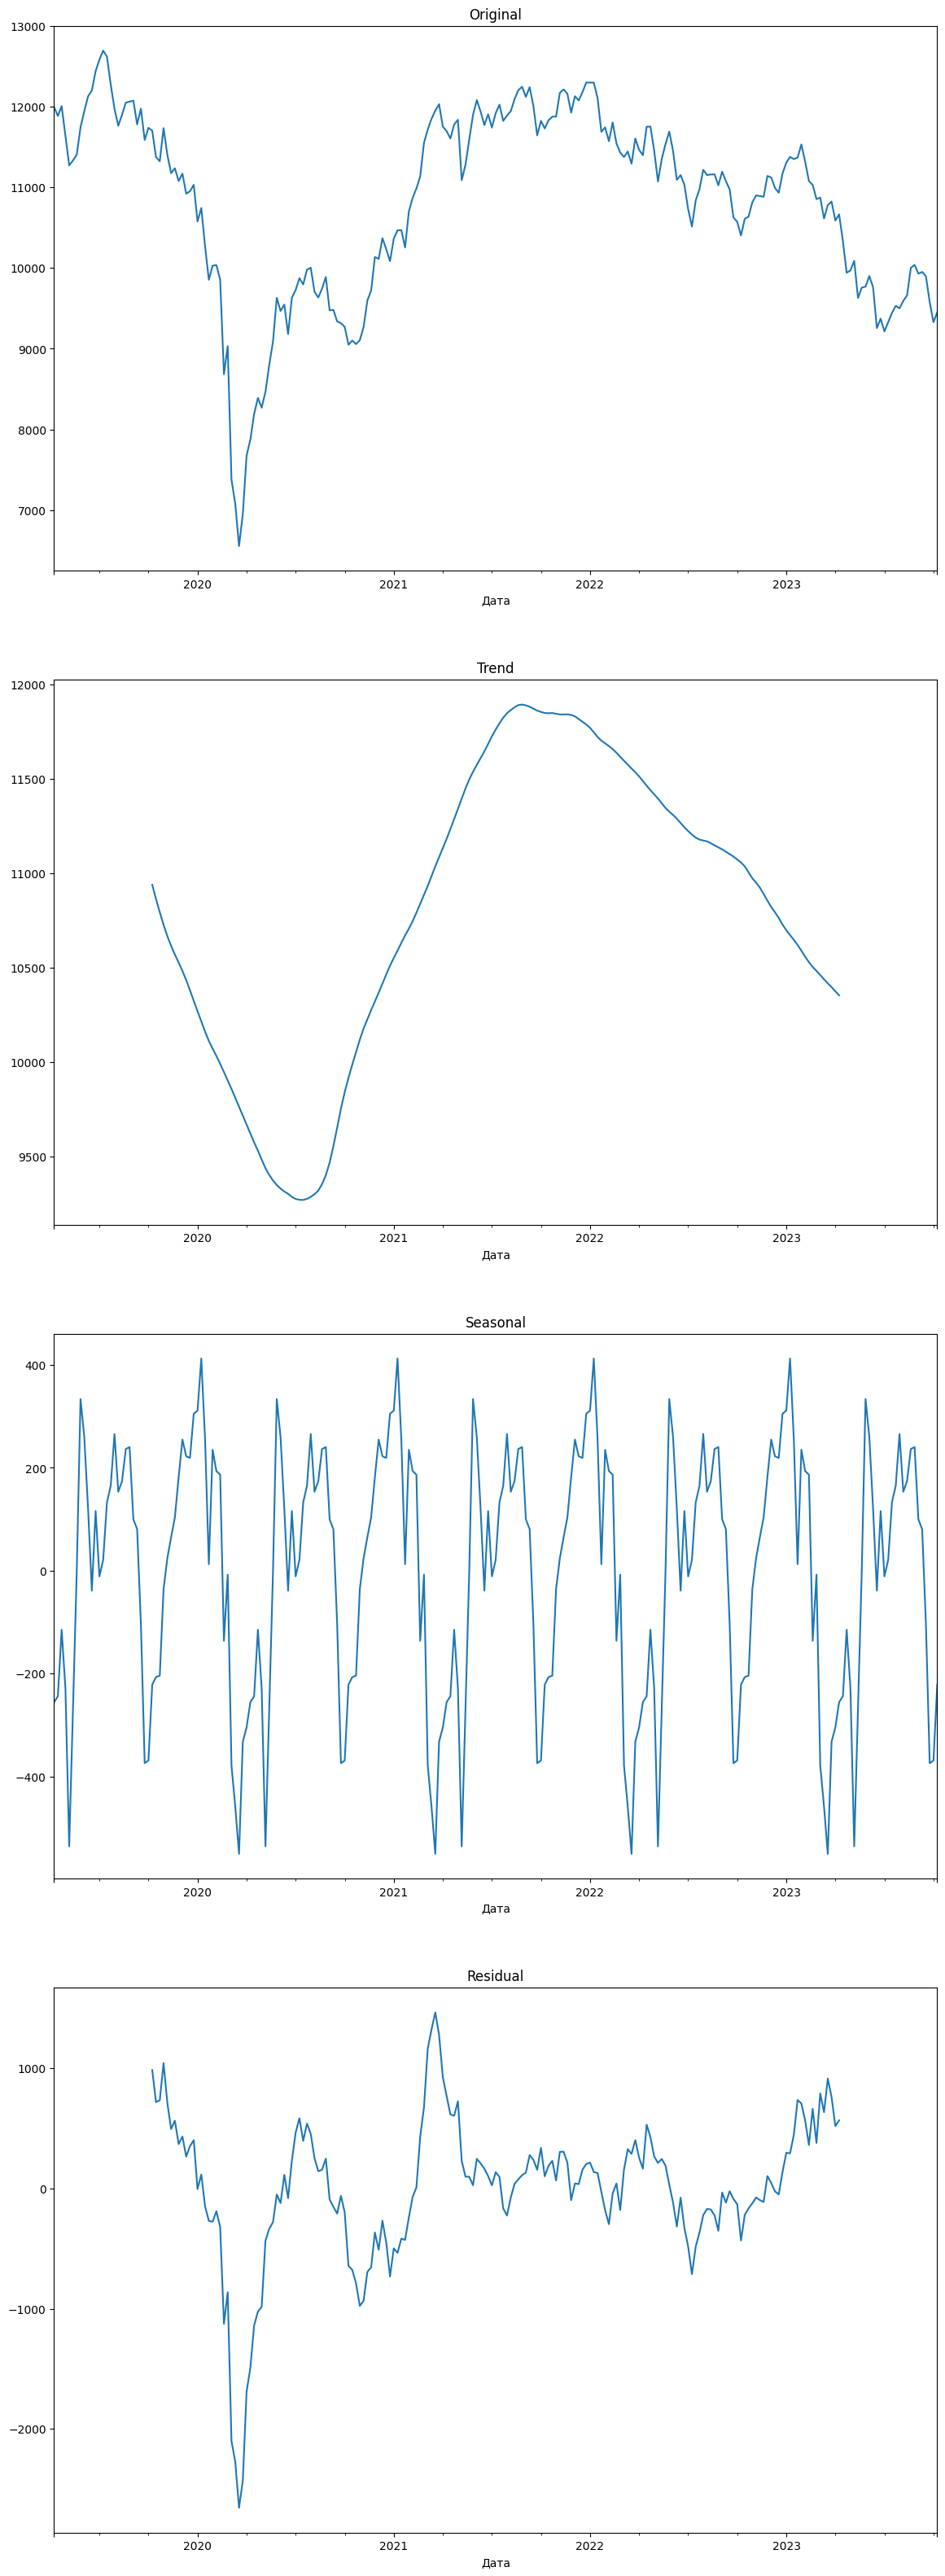

In [340]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df['Цена'], period=52)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

### Декомпозиция моего ряда ###

<Axes: title={'center': 'Residual'}, xlabel='Дата'>

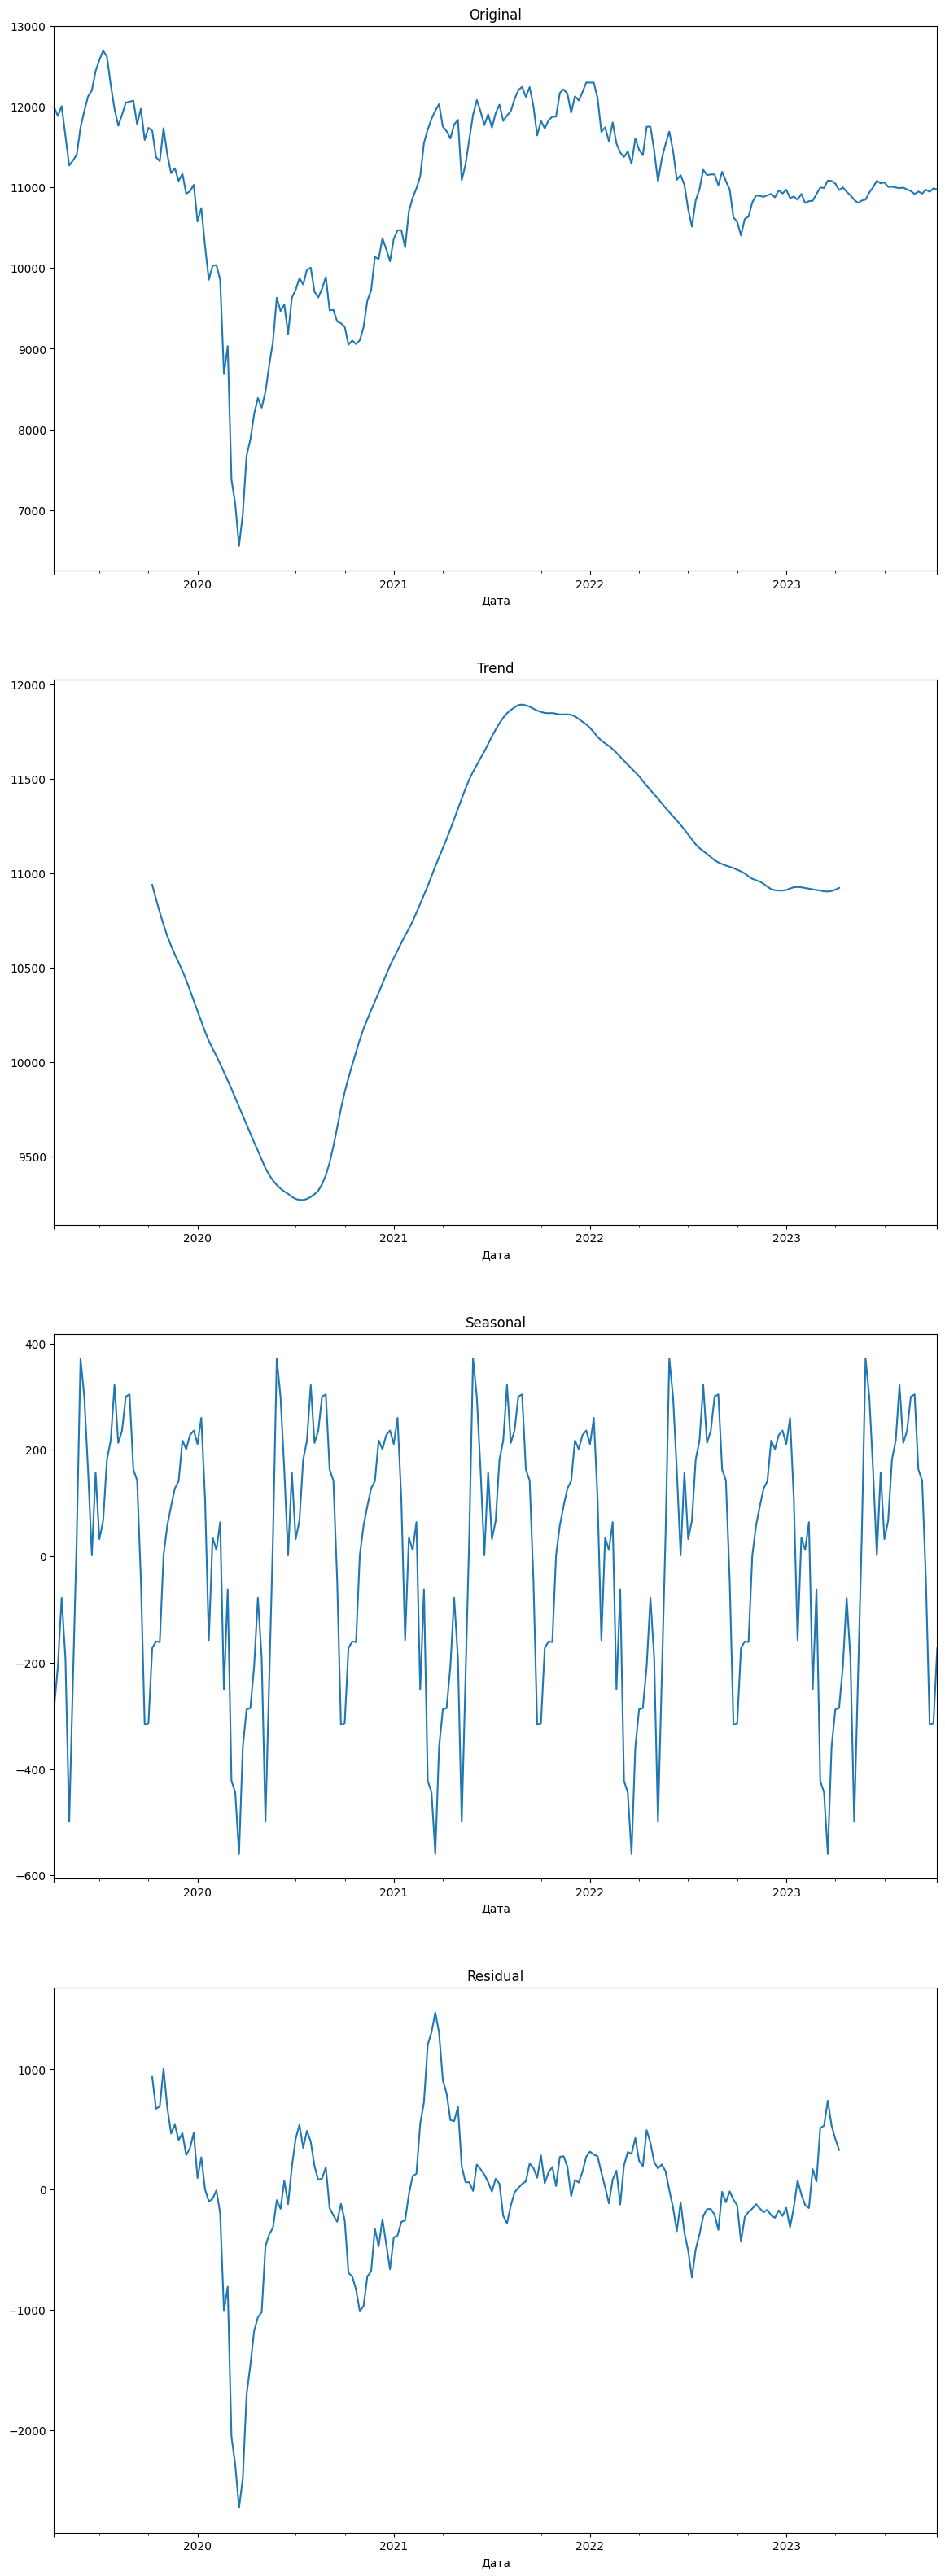

In [341]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df['ПредсказNoDiff'], period=52)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])